**PClub Transfer Learning Hackathon**

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle/ #make a new directory .kaggle

Create a Kaggle Account. Then follow the steps given here to download the API key file. It is very simple!

[Kaggle API Credentials](https://github.com/Kaggle/kaggle-api#api-credentials)

Just download the file, and upload it here to the Colab Environment.

In [ ]:
!cp kaggle.json ~/.kaggle/ #copy uploaded file in the .kaggle file
!chmod 600 ~/.kaggle/kaggle.json # Giving permissions
!kaggle datasets list # Let's see if everything is working

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
shivan118/healthcare-analytics                         AV : Healthcare Analytics                           2MB  2020-09-13 17:40:05           2398  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification        4MB  2020-09-08 11:40:11           1718  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           2958  
Cornell-University/arxiv                               arXiv Dataset                                     889MB  2020-09-26 23:51:17           3202  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification # Downloading the dataset
!unzip intel-image-classification.zip #unzip file
!rm -rf intel-image-classification.zip #remove zip file

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating: seg_train/seg_train/mountain/7695.jp

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as loader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import glob #for pattern matching in file pathnames

In [ ]:
data = glob.glob('seg_train/**/*.jpg',recursive=True) #A list of file paths with .jpg extensions
classes = []
for f in data :
  arr = f.split('/') # a list with deeper level of file structure coming at the end
  if arr[-2] not in classes:
    classes.append(arr[-2]) #last 2nd element i.e. folders which contain the images.
print(classes)
print(len(classes))

['street', 'glacier', 'forest', 'sea', 'buildings', 'mountain']
6


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
class PClubDataset(Dataset):
  """
  dataset class build to load the Data
  dir (string) : Directory where files have been extracted
  train (bool):True if training dataset . False for Testing 
  """
  def __init__(self,dir= './',transform = None , train = True): # initializer for class
    #Default for train_data and no transform
    self.dir = dir
    self.train = train
    self.transform = transform
    if train is True:
      self.data = glob.glob('seg_train/**/*.jpg',recursive=True)
    if train is False:
      self.data = glob.glob('seg_test/**/*.jpg',recursive=True)
    self.classes = ['sea', 'forest', 'street', 'mountain', 'glacier', 'buildings']

  def __len__(self):
    return (len(self.data)-1)  # -1 most probably for setting last index directly

  def __getitem__(self,ind): #get item at given index
    image = Image.open(self.data[ind])
    if self.transform is not None:
      image = self.transform(image)
    label = self.classes.index(self.data[ind].split('/')[-2])  
    #return the index of corresponding classes 
    #i.e a image of category 'sea' will return 0
    label = torch.tensor([label])
    return image,label #return image and its corresponding label in the form of tensor

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),]
)
trainset = PClubDataset(transform = transform , train = True)
#Note transform is necessary if we want to do operations on image

torch.Size([3, 150, 150]) tensor([2])
forest
(150, 150, 3)


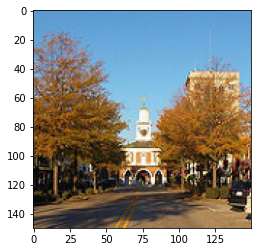

torch.Size([3, 150, 150]) tensor([4])
buildings
(150, 150, 3)


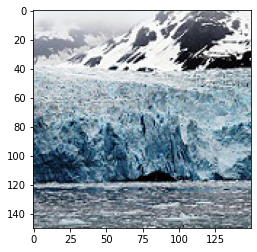

torch.Size([3, 150, 150]) tensor([3])
sea
(150, 150, 3)


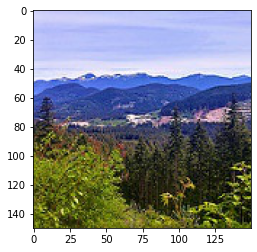

torch.Size([3, 150, 150]) tensor([4])
buildings
(150, 150, 3)


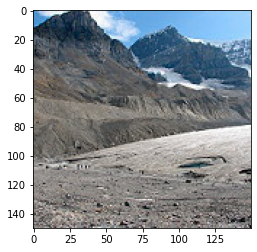

torch.Size([3, 150, 150]) tensor([2])
forest
(150, 150, 3)


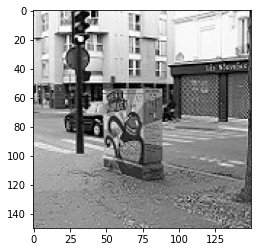

In [ ]:
#Plotting sample images
import random
for i in range(5):
  n = random.randint(0,12000)
  sample = trainset.__getitem__(n)
  print(sample[0].shape,sample[1])
  print(classes[sample[1]])
  img = np.array(sample[0]).transpose((1,2,0)) #transform image to h x w x 3 from 3 x h x w
  #transform rearrange the values in the order of input tuples,starting from (0,1,2,...) 
  print(img.shape)
  plt.imshow(img) 
  plt.show()
  


In [ ]:
transform = transforms.Compose([
                                transforms.Resize(size = (150,150)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                
])
# the image data is normalized with a mean and standard deviation given
trainset = PClubDataset(transform=transform,train = True)
trainloader = loader.DataLoader(dataset = trainset,batch_size=16,shuffle=True,drop_last=True)

In [ ]:
# minibatches for validation
val_loader = loader.DataLoader(dataset = trainset,batch_size=128,shuffle = True,drop_last=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


In [ ]:
#We shall use the Resnet-50 pretrained model here.
model = torchvision.models.resnet50(pretrained=True).to(device)
for param in model.parameters():
  param.requires_grad = False
#We will replace a layer
num_ftrs = model.fc.in_features #input features of fully connected layer which is the last one

# Replace fc layer of model with our layer which will have 6 output channels instead of original channels
model.fc = nn.Linear(in_features=num_ftrs,out_features=len(classes)).to(device)

#Let us see our model
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Move model to gpu
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(),lr = 0.003)

# Training loop
List different times below with required changes:
* It goes like this

In [ ]:
import time

In [ ]:
def train(model,n_epochs):
  print("===========HyperParameters=========")
  print("n_epochs = ",n_epochs  )

  n_minibatches = len(trainloader)

  #For plotting the loss
  train_history = []
  val_history = []

  training_start_time = time.time()
  
  for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = n_minibatches//10
    start_time = time.time()
    total_train_loss = 0

    for i , (images,labels) in enumerate(trainloader):

      images , labels = images.to(device), labels.to(device)
      labels = labels.squeeze()

      optimizer.zero_grad()
      
      #forward + backward + optimize

      outputs = model(images)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      #print statistics
      running_loss += loss.item()
      total_train_loss += loss.item()

      #print every 10 th of epoch
      if(i+1)% (print_every +1) == 0:
        print("Epoch {},{:d}% \t train_loss: {:.2f} took : {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
        running_loss = 0.0
        start_time = time.time()
    train_history.append(total_train_loss / len(trainloader))
    total_val_loss = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
          # Move tensors to correct device
          inputs, labels = inputs.to(device), labels.to(device)
          
          # Forward pass
          predictions = model(inputs)
          labels = labels.squeeze()
          val_loss = criterion(predictions, labels)
          total_val_loss += val_loss.item()
              
    val_history.append(total_val_loss / len(val_loader))
    print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    

  print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
  
  return train_history,val_history
    
  

In [ ]:
train_history,val_history = train(model,n_epochs=2)

===========HyperParameters=========
n_epochs =  2
Epoch 1,10% 	 train_loss: 1.34 took : 4.04s
Epoch 1,20% 	 train_loss: 0.88 took : 3.88s
Epoch 1,30% 	 train_loss: 0.70 took : 3.88s
Epoch 1,40% 	 train_loss: 0.63 took : 3.87s
Epoch 1,50% 	 train_loss: 0.56 took : 3.86s
Epoch 1,60% 	 train_loss: 0.49 took : 3.79s
Epoch 1,70% 	 train_loss: 0.52 took : 3.82s
Epoch 1,80% 	 train_loss: 0.49 took : 3.83s
Epoch 1,90% 	 train_loss: 0.47 took : 3.82s
Validation loss = 0.37
Epoch 2,10% 	 train_loss: 0.45 took : 3.90s
Epoch 2,20% 	 train_loss: 0.42 took : 3.89s
Epoch 2,30% 	 train_loss: 0.42 took : 3.84s
Epoch 2,40% 	 train_loss: 0.41 took : 3.91s
Epoch 2,50% 	 train_loss: 0.43 took : 3.85s
Epoch 2,60% 	 train_loss: 0.40 took : 3.88s
Epoch 2,70% 	 train_loss: 0.42 took : 3.87s
Epoch 2,80% 	 train_loss: 0.41 took : 3.88s
Epoch 2,90% 	 train_loss: 0.41 took : 3.88s
Validation loss = 0.33
Training Finished, took 160.64s


In [ ]:
print(train_history)

[0.64549780695645, 0.4118899363119627]


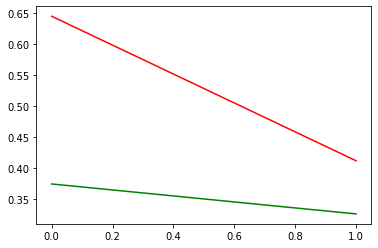

In [ ]:
plt.plot(train_history,c='r')
plt.plot(val_history,c='g')
plt.show()

In [ ]:
testset = PClubDataset(transform=transform,train = False)
test_loader = loader.DataLoader(dataset = testset,batch_size=16,shuffle=True,drop_last=True)

In [ ]:
classes = ['sea', 'forest', 'street', 'mountain', 'glacier', 'buildings']

In [ ]:
def imshow(img):
  img = img/2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

16


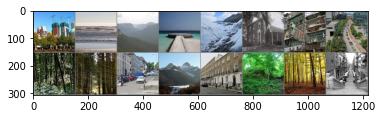

Ground Truth :  buildings   sea mountain   sea glacier buildings buildings street forest forest street mountain street forest forest street
Predicted:      buildings   sea mountain   sea glacier buildings buildings buildings forest forest street mountain buildings forest forest street


In [ ]:
dataiter = iter(test_loader)
images , labels = dataiter.next()
print(labels.size(0))

imshow(torchvision.utils.make_grid(images))
print('Ground Truth : ',' '.join('%5s' % classes[labels[j]] for j in range(16)))

images = images.to(device)
outputs = model(images)
_,predicted = torch.max(outputs,1)

print('Predicted:     ',' '.join('%5s' %classes[predicted[j]] for j in range(16)))

In [ ]:
def accuracy(data_loader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in data_loader:
      images , labels = data
      # imshow(torchvision.utils.make_grid(images))
      # print('Ground Truth : ',' '.join('%5s' % classes[labels[j]] for j in range(16)))
      images = images.to(device)
      labels = labels.to(device)
      labels = labels.squeeze()
      outputs = model(images)
      _,predicted = torch.max(outputs,1)
      # print('Predicted:     ',' '.join('%5s' %classes[predicted[j]] for j in range(16)))
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the %d images : %d %%'%(total,100*correct/total))

In [ ]:
accuracy(trainloader)
accuracy(val_loader)
accuracy(test_loader)

Accuracy of the network on the 14032 images : 86 %
Accuracy of the network on the 13952 images : 88 %
Accuracy of the network on the 2992 images : 86 %


In [70]:
torch.save(model.state_dict(),'models/pytorch/weight.h5')